## Exploration Project 10

#### Let's make a translator

<hr>

### Step 0. 라이브러리와 데이터 준비
<hR>

~~~
실습에서 구현한 번역기는 글자 단위(Character-level)에서 구현된 번역기였습니다.

하지만 실제 번역기의 경우에는 글자 단위가 아니라 단어 단위(Word-level)에서 구현되는 것이 좀 더 보편적입니다.

동일한 데이터셋을 사용하면서 글자 단위와는 다른 전처리와 임베딩 층(Embedding layer)를 추가하여 

단어 단위의 번역기를 완성시켜보겠습니다.

하지만, 단어 단위로 할 경우에는 단어의 개수가 글자 단위로 했을 경우와 비교하여

단어장의 크기(Vocabulary) 크기도 커지고, 학습 속도도 좀 더 느려집니다. 

학습과 테스트 시의 원활한 진행을 위해서 데이터에서 상위 33,000개의 샘플만 사용해주세요.

33000개 중 3000개는 테스트 데이터로 분리하여 모델을 학습한 후에 번역을 테스트 하는 용도로 사용합니다.
~~~

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import os

file_path = os.getenv("HOME")+"/aiffel/translator_seq2seq/data/fra.txt"
lines = pd.read_csv(file_path, names=["eng", "fra", "cc"], sep="\t")
print("전체 샘플의 수 :",len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 197463


,eng,fra,cc
194541,Are you seriously thinking about buying a comp...,Pensez-vous sérieusement à faire l'acquisition...,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
58246,It was your own choice.,C'était votre choix.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
177330,I have about three times as many books as Tom.,J'ai environ trois fois plus de livres que Tom.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
51118,It gave me the creeps.,Cela me donne la chair de poule.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
173348,I don't see what you two are so happy about.,Je ne vois pas de quoi vous êtes tellement con...,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


### Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)

<hr>

~~~
글자 단위가 아닌 단어 단위의 번역기를 하기 위해서는 글자 단위에서는 신경쓰지 않았던 몇 가지 추가적인 전처리가 필요합니다.

1. 구두점(Punctuation)을 단어와 분리해주세요.

    일반적으로 영어권 언어의 경우에는 띄어쓰기 단위로 단어를 분리합니다.
    토큰화(Tokenization)이라고도 불리는 이 작업은 어디서부터 어디까지가 하나의 단어인지를 구분하는 작업인데요.
    그런데 띄어쓰기를 해주기 전에 구두점을 분리하는 작업이 필요할 때가 있습니다.

    예를 들어서 'he is a good boy!'라는 문장이 있을 때, 이를 띄어쓰기 단위로 토큰화한다면

    ['he', 'is', 'a', 'good', 'boy!']가 됩니다. 그런데 실제로 !는 boy와 붙어있는 한 단어가 아니므로

    좀 더 올바른 전처리는 ['he', 'is', 'a', 'good', 'boy', '!']가 맞습니다.

    !나 ? 또는 온점과 같은 특수문자들을 구두점(punctuation)이라고 부릅니다.

    이들을 토큰화하기 전에 단어와 미리 분리시켜주세요!

    분리 전 : he is a Good boy!

    분리 후 : he is a Good boy !


2. 소문자로 바꿔주세요.

    기계가 보기에는 스펠링이 같더라도 대문자로 된 단어와 소문자로 된 단어는 서로 다른 단어입니다. 
    예를 들어 'Good'과 'good'은 기계가 보기에는 다른 단어입니다. 
    그래서 모든 문장에 대해서 전부 영어로 바꿔주는 작업을 하겠습니다.

    변환 전 : he is a Good boy !

    변환 후 : he is a good boy !


3. 띄어쓰기 단위로 토큰를 수행하세요.

    띄어쓰기 단위로 토큰화를 수행해서 단어를 분리하는 작업을 해주세요. 
    기계는 이렇게 분리된 토큰들을 각각 하나의 단어로 인식할 수 있게 됩니다.

    토큰화 전 : 'he is a good boy !'

   토큰화 후 : ['he', 'is', 'a', 'good', 'boy', '!']
   
   

세번째 열(cc：Creative Commons)은 불필요하므로 제거하고, 훈련 데이터는 3.3만개의 샘플로 줄이겠다.

In [2]:
num_samples = 33000

# lines = lines[['eng', 'fra']][:num_samples] # 3.3만개 샘플 사용
# lines.sample(5)

정규 표현식을 통한 전처리를 하려고 영문자와 구두점이 뭐가 있나 찾으려고 보다보니…

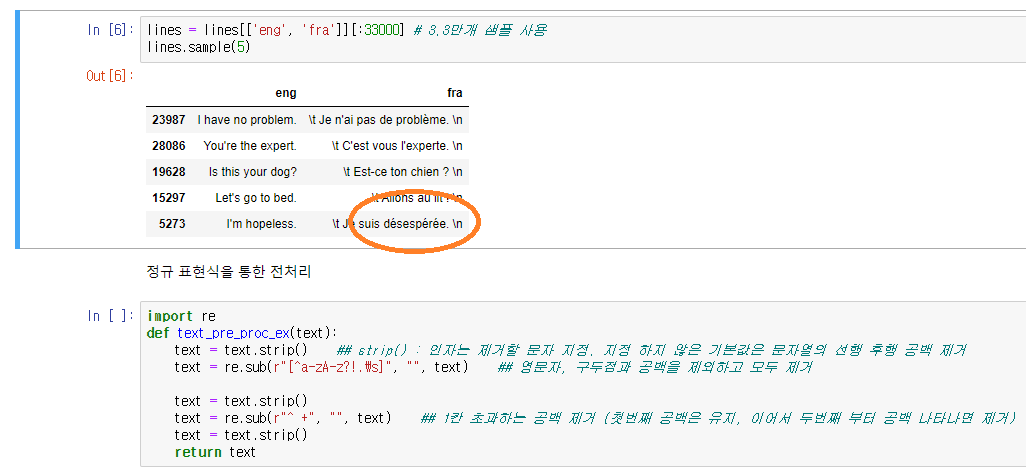

이건 영문자 아니라고 삭제가 될 것 같다.

구두점과 문자들을 한번 싹 검색을 해 보고 남길지 말지 결정을 해봐야 할 것 같다.

- [Regex Python french accent](https://stackoverflow.com/questions/62125687/regex-python-french-accent)

전처리 함수는 아래의 참고자료에서 가져와서 조금 변경하도록 하겠다.

- [딥 러닝을 이용한 자연어 처리 입문 14. RNN을 이용한 인코더-디코더<br>2) Word-Level 번역기 만들기(Neural Machine Translation (seq2seq) Tutorial)](https://wikidocs.net/86900)

어지간해선 문제 될 것 같지 않지만, 소문자와 공백문자에 대한 처리에 조금 더 신경을 썼다.

In [3]:
import re
import unicodedata
# def text_pre_proc_ex(text):
#     text = text.strip()    ## strip() : 인자는 제거할 문자 지정. 지정 하지 않은 기본값은 문자열의 선행 후행 공백 제거
#     text = re.sub(r"[^-,.?!A-zÀ-ú\s]", "", text)    ## 영문자, 구두점과 공백을 제외하고 모두 제거
#     text = text.strip()
#     text = re.sub(r"^ +", "", text)    ## 1칸 초과하는 공백 제거 (첫번째 공백은 유지, 이어서 두번째 부터 공백 나타나면 제거)
#     text = text.strip()
#     return text

def to_ascii(s):
    # 프랑스어 악센트(accent) 삭제
    # 예시 : 'déjà diné' -> deja dine
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sent):
    # 악센트 제거 함수 호출
    sent = to_ascii(sent.lower())

    # 단어와 구두점 사이에 공백 추가.
    # ex) "I am a student." => "I am a student ."
    sent = re.sub(r"([?.!,¿])", r" \1", sent)

    # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환.
    sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

    # 소문자로 변경
    sent = sent.lower()

    # 다수 개의 공백을 하나의 공백으로 치환
    sent = re.sub(r"\s+", " ", sent)
    
    return sent

구현한 전처리 함수들을 임의의 문장을 입력으로 테스트

In [4]:
eng_sent = u"Have you had dinner?"
fra_sent = u"Avez-vous déjà diné?"

print("전처리 전 영어 문장 :", eng_sent)
print("전처리 후 영어 문장 :",preprocess_sentence(eng_sent))
print("전처리 전 프랑스어 문장 :", fra_sent)
print("전처리 후 프랑스어 문장 :", preprocess_sentence(fra_sent))

전처리 전 영어 문장 : Have you had dinner?
전처리 후 영어 문장 : have you had dinner ?
전처리 전 프랑스어 문장 : Avez-vous déjà diné?
전처리 후 프랑스어 문장 : avez vous deja dine ?


이제 전체 데이터에서 33,000개의 샘플에 대해서 전처리를 수행하겠다.

또한 훈련 과정에서 교사 강요(Teacher Forcing)을 사용할 예정이고, 

노드에서 문자 Level 번역기 실습 부분과 전체적인 흐름은 크게 다르지 않으므로,

문자 Levle 번역기 실습 컨셉을 유사하게 따르도록 하겠다.

여기서도 역시, 훈련 시 사용할 디코더의 입력 시퀀스와 실제값. 즉, 레이블에 해당되는 출력 시퀀스를 따로 분리하여 저장할 것이다.

encoder_input, decoder_input, decoder_target 각각 분리하여 데이터를 할당한다.

seq2seq 동작을 위해서 디코더의 입력과 예측에 시작 토큰 \<sos\> 와 종료 토큰 \<eos\> 도 같이 적용하도록 하겠다.

In [5]:
def load_preprocessed_data():

    encoder_input, decoder_input, decoder_target = [], [], []

    with open(file_path, "r") as lines:
    
        for i, line in enumerate(lines):
            # source 데이터와 target 데이터 분리
            src_line, tar_line, _ = line.strip().split("\t")

            # source 데이터 전처리
            src_line = [w for w in preprocess_sentence(src_line).split()]

            # target 데이터 전처리
            tar_line = preprocess_sentence(tar_line)
            tar_line_in = [w for w in ("<sos> " + tar_line).split()]
            tar_line_out = [w for w in (tar_line + " <eos>").split()]

            encoder_input.append(src_line)
            decoder_input.append(tar_line_in)
            decoder_target.append(tar_line_out)

            if i == num_samples - 1:
                break

    return encoder_input, decoder_input, decoder_target

이렇게 얻은 3개의 데이터셋 인코더의 입력, 디코더의 입력, 디코더의 일부를 출력하여 내용을 확인해 보자.

In [6]:
sents_eng_in, sents_fra_in, sents_fra_out = load_preprocessed_data()

print("인코더의 입력1 :",sents_eng_in[:3])
print()
print("디코더의 입력1 :",sents_fra_in[:3])
print()
print("디코더의 라벨1 :",sents_fra_out[:3])
print()
print()
print("인코더의 입력2 :",sents_eng_in[-3:])
print()
print("디코더의 입력2 :",sents_fra_in[-3:])
print()
print("디코더의 라벨2 :",sents_fra_out[-3:])

인코더의 입력1 : [['go', '.'], ['go', '.'], ['go', '.']]

디코더의 입력1 : [['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'en', 'route', '!']]

디코더의 라벨1 : [['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['en', 'route', '!', '<eos>']]


인코더의 입력2 : [['we', 'also', 'found', 'this', '.'], ['we', 'are', 'busy', 'people', '.'], ['we', 'are', 'watching', 'tv', '.']]

디코더의 입력2 : [['<sos>', 'nous', 'avons', 'aussi', 'trouve', 'ceci', '.'], ['<sos>', 'nous', 'sommes', 'des', 'gens', 'occupes', '.'], ['<sos>', 'nous', 'regardons', 'la', 'television', '.']]

디코더의 라벨2 : [['nous', 'avons', 'aussi', 'trouve', 'ceci', '.', '<eos>'], ['nous', 'sommes', 'des', 'gens', 'occupes', '.', '<eos>'], ['nous', 'regardons', 'la', 'television', '.', '<eos>']]


~~~
모델을 설계하기 전 의아한 점이 있을 수 있습니다. 현재 시점의 디코더 셀의 입력은 오직 이전 디코더 셀의 출력을 입력으로 받는다고 설명하였는데 디코더의 입력에 해당하는 데이터인 sents_fra_in이 왜 필요할까요?

훈련 과정에서는 이전 시점의 디코더 셀의 출력을 현재 시점의 디코더 셀의 입력으로 넣어주지 않고, 이전 시점의 실제값을 현재 시점의 디코더 셀의 입력값으로 하는 방법을 사용할 겁니다. 그 이유는 이전 시점의 디코더 셀의 예측이 틀렸는데 이를 현재 시점의 디코더 셀의 입력으로 사용하면 현재 시점의 디코더 셀의 예측도 잘못될 가능성이 높고 이는 연쇄 작용으로 디코더 전체의 예측을 어렵게 합니다. 이런 상황이 반복되면 훈련 시간이 느려집니다. 만약 이 상황을 원하지 않는다면 이전 시점의 디코더 셀의 예측값 대신 실제값을 현재 시점의 디코더 셀의 입력으로 사용하는 방법을 사용할 수 있습니다. 이와 같이 RNN의 모든 시점에 대해서 이전 시점의 예측값 대신 실제값을 입력으로 주는 방법을 교사 강요라고 합니다.
~~~

### Step 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.

<hr>

~~~
글자 단위 번역기를 구현할 때와 마찬가지로 디코더의 입력 시퀀스 맨 앞에는 시작을 의미하는 토큰인 가 필요합니다. 그리고 교사 강요를 수행할 때, 디코더의 실제값이 되는 디코더의 레이블 시퀀스에는 종료를 의미하는 종료 토큰 가 필요합니다.

예를 들어 번역 문장이 Courez!이었다고 한다면, Step 1을 거친 후에는 다음과 같은 결과를 얻습니다.

Step 1을 수행한 후 : ['courez', '!']

이 문장에 대해서 각각 디코더의 입력 시퀀스와 레이블 시퀀스를 만들면 다음과 같습니다.

입력 시퀀스 : ['', 'courez', '!']

레이블 시퀀스 : ['courez', '!', ']

참고로 Step 2가 반드시 Step 1이 끝난 후에 이루어질 필요는 없습니다!

Step 1을 수행하는 중간에 수행해도 상관없습니다.
~~~

Step.2 과정은 Step.1 을 수행하는 중간에 마친 상태이다.

### Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.

<hr>

~~~
딥 러닝 모델은 각 단어를 텍스트가 아닌 숫자를 처리합니다. 케라스 토크나이저를 사용해서 각 단어를 고유한 정수로 바꿔보세요. 케라스 토크나이저의 사용법은 아래의 링크에서 2. 케라스(Keras)의 텍스트 전처리 에 설명되어져 있습니다.
~~~
 - [위키독스](https://wikidocs.net/31766)
 
~~~
위 링크의 가이드를 통해서 영어와 프랑스어에 대한 토크나이저를 각각 생성하고,

tokenizer.texts_to_sequences()를 사용하여 모든 샘플에 대해서 정수 시퀀스로 변환해보세요.
~~~

~~~
인코더의 입력으로 사용되는 영어 시퀀스와 달리, 프랑스어 시퀀스는 2가지 버전으로 나누어 준비해야 합니다. 하나는 디코더의 출력과 비교해야 할 정답 데이터로 사용해야 할 원래 목적에 따른 것입니다. 그리고 다른 하나는 이전 스텝에서 언급했던 교사 강요(Teacher forcing)을 위해 디코더의 입력으로 사용하기 위한 것입니다.

이때, 디코더의 입력으로 사용할 시퀀스는 <eos>토큰이 필요가 없고, 디코더의 출력과 비교할 시퀀스는 <sos>가 필요가 없기 때문입니다. 가령, 영어로 'I am a person'이라는 문장을 프랑스어 'Je suis une personne'로 번역하는 번역기를 만든다고 해봅시다. 훈련 과정에서 디코더는 '<sos> Je suis une personne'를 입력받아서 'Je suis une personne <eos>'를 예측하도록 훈련되므로, 이런 방식으로 생성된 두가지 버전의 시퀀스를 준비해야 합니다.
~~~

케라스 토크나이저를 통해 단어 집합을 생성, 정수 인코딩을 진행한다.

모델에 입력될 시퀀스의 길이를 일정하게 맞추어야 하므로,

최대 길이에 맞추고, 남는 시퀀스 뒷부분은 패딩을 진행하여 (0 으로) 채워준다.

In [7]:
## 정수 인코딩과 패딩 - Eng
tokenizer_eng = Tokenizer(filters="", lower=False)

tokenizer_eng.fit_on_texts(sents_eng_in)
encoder_input = tokenizer_eng.texts_to_sequences(sents_eng_in)
encoder_input = pad_sequences(encoder_input, padding="post")

## 정수 인코딩과 패딩 - Fra
tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)

decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_input = pad_sequences(decoder_input, padding="post")

decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)
decoder_target = pad_sequences(decoder_target, padding="post")

정상적으로 정수 시퀀스로 변환되었는지 내용을 출력하여 확인

In [8]:
encoder_input[-5:]

array([[ 12,  38, 454,   9, 156,   1,   0,   0],
       [ 12,  38, 116, 224,   1,   0,   0,   0],
       [ 12, 861, 204,  19,   1,   0,   0,   0],
       [ 12,  21, 100, 882,   1,   0,   0,   0],
       [ 12,  21, 689, 406,   1,   0,   0,   0]], dtype=int32)

In [9]:
decoder_input[-5:]

array([[   2,   17,   68,  110,  137,  452,    1,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   2,   17,  832,   81,  208,    1,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   2,   17,   68,  247,  151,  101,    1,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   2,   17,   43,   51,  965,  537,    1,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   2,   17, 2051,   22, 1059,    1,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0]], dtype=int32)

인덱스 2 (\<sos\>)로 시작한다.

In [10]:
decoder_target[-5:]

array([[  17,   68,  110,  137,  452,    1,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [  17,  832,   81,  208,    1,    3,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [  17,   68,  247,  151,  101,    1,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [  17,   43,   51,  965,  537,    1,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [  17, 2051,   22, 1059,    1,    3,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0]], dtype=int32)

인덱스 3 (\<eos\>) 로 끝난다.

데이터의 크기(shape)를 확인

In [11]:
print("인코더의 입력의 크기(shape) :",encoder_input.shape)
print("디코더의 입력의 크기(shape) :",decoder_input.shape)
print("디코더의 레이블의 크기(shape) :",decoder_target.shape)

인코더의 입력의 크기(shape) : (33000, 8)
디코더의 입력의 크기(shape) : (33000, 16)
디코더의 레이블의 크기(shape) : (33000, 16)


단어 집합의 크기를 정의.

0번 토큰（패딩）을 고려하여 +1 의 크기로 지정해 준다.

In [12]:
eng_vocab_size = len(tokenizer_eng.word_index) + 1
fra_vocab_size = len(tokenizer_fra.word_index) + 1

print("영어 단어장의 크기 :", eng_vocab_size)
print("프랑스어 단어장의 크기 :", fra_vocab_size)

영어 단어장의 크기 : 4672
프랑스어 단어장의 크기 : 8137


영어 데이터와 프랑스어 데이터의 최대 길이를 각각 구해보자.

노드에서의 문자 Level 번역기 실습 부분에서는,

패딩을 위해 모델에 입력될 영어, 프랑스어 시퀀스의 길이를

최대 길이로 맞추어 시퀀스의 길이를 일정하게 하고,

남는 시퀀스 뒷부분을 패딩으로 채우기 위한 고려를 했었다.

그렇지만, 여기서는 전처리 과정에서 패딩 작업을 이미 수행한 상태라,

최대 길이에 맞추어 패딩 과정이 끝난 상태이다.

그래서 이하의 코드를 통해, 단어의 최대 길이만 구해놓도록 하겠다.

단어 단위로 처리 할 것이므로, 문자 Level 실습시보다 시퀀스의 길이는 짧을 것이다.

In [13]:
max_eng_seq_len = max([len(line) for line in encoder_input])
max_fra_seq_len = max([len(line) for line in decoder_target])

print("영어 시퀀스의 최대 길이 :", max_eng_seq_len)
print("프랑스어 시퀀스의 최대 길이 :", max_fra_seq_len)

영어 시퀀스의 최대 길이 : 8
프랑스어 시퀀스의 최대 길이 : 16


전체적인 통계 정보를 한꺼번에 출력해보자.

In [14]:
print("전체 샘플의 수 :",len(lines))
print("영어 단어장의 크기 :", eng_vocab_size)
print("프랑스어 단어장의 크기 :", fra_vocab_size)
print("영어 시퀀스의 최대 길이 :", max_eng_seq_len)
print("프랑스어 시퀀스의 최대 길이 :", max_fra_seq_len)

전체 샘플의 수 : 197463
영어 단어장의 크기 : 4672
프랑스어 단어장의 크기 : 8137
영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 16


단어로부터 정수를 얻는데에 사용할 딕셔너리와,

정수로부터 단어를 얻는데에 사용할 딕셔너리를 각각 생성.

__※ 훈련을 마치고 예측값과 실제값을 비교하는 단계에서 사용할 것이다.__

In [15]:
eng2idx = tokenizer_eng.word_index
idx2eng = tokenizer_eng.index_word
fra2idx = tokenizer_fra.word_index
idx2fra = tokenizer_fra.index_word

테스트 데이터를 분리하기 전 데이터를 섞기 위해서, 먼저 순서가 섞인 정수 시퀀스 리스트를 만든다.

이를 데이터셋의 순서로 지정해주면 샘플들이 기존 순서와 다른 순서로 섞이게 된다.

In [16]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print("np.max(indices) :", np.max(indices))
print("np.min(indices) :", np.min(indices))
print("랜덤 시퀀스 :", indices)

np.max(indices) : 32999
np.min(indices) : 0
랜덤 시퀀스 : [ 2389 18584 22921 ...  6312 12480 10725]


In [17]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

샘플을 출력해 봤을때, decoder_input과 decoder_target은, 데이터의 구조상으로

앞에 붙은 \<sos\> 토큰과 뒤에 붙은 \<eos\>을 제외하면 동일한 정수 시퀀스를 가져야 한다.

In [18]:
print("encoder_input[12345] :", encoder_input[12345])
print("decoder_input[12345] :", decoder_input[12345])
print("decoder_target[12345] :", decoder_target[12345])

encoder_input[12345] : [  2  83  27 525   1   0   0   0]
decoder_input[12345] : [   2    4 1489    8  125  888    1    0    0    0    0    0    0    0
    0    0]
decoder_target[12345] : [   4 1489    8  125  888    1    3    0    0    0    0    0    0    0
    0    0]


decoder_input 에서 맨 처음의 2 (\<sos\>) 와

decoder_target 에서 마지막 패딩 전의 3 (\<eos\>) 토큰을 제외한 나머지에서

decoder_input과 decoder_target은 동일한 시퀀스임을 확인 할 수 있다.

이제 훈련 데이터에서 3000개를 테스트 데이터로 사용하겠다.

In [19]:
n_of_val = int(3000)
print("검증 데이터의 개수 :", n_of_val)

검증 데이터의 개수 : 3000


훈련 데이터와 테스트 데이터를 분리하겠다.

In [20]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [21]:
print("encoder_input_train.shape :", encoder_input_train.shape)
print("decoder_input_train.shape :", decoder_input_train.shape)
print("decoder_target_train.shape :", decoder_target_train.shape)
print()
print("encoder_input_test.shape :", encoder_input_test.shape)
print("decoder_input_test.shape :", decoder_input_test.shape)
print("decoder_target_test.shape :", decoder_target_test.shape)

encoder_input_train.shape : (30000, 8)
decoder_input_train.shape : (30000, 16)
decoder_target_train.shape : (30000, 16)

encoder_input_test.shape : (3000, 8)
decoder_input_test.shape : (3000, 16)
decoder_target_test.shape : (3000, 16)


### Step 4. 임베딩 층(Embedding layer) 사용하기

<hr>

~~~
이번에는 입력이 되는 각 단어를 임베딩 층을 사용하여 벡터화하겠습니다.

임베딩 층을 사용하는 방법과 그 설명에 대해서는 아래의 링크의

1. 케라스 임베딩 층(Keras Embedding layer) 를 참고하세요.
~~~

 - [위키독스](https://wikidocs.net/33793)

~~~
실제 번역기 구현을 위해서 사용할 수 있는 인코더 코드의 예시는 다음과 같습니다.

이를 통해서 인코더와 디코더의 임베딩 층을 각각 구현해보세요.
~~~


─────────────────────────────────────────────────────────────────
~~~python
from tensorflow.keras.layers import Input, Embedding, Masking

# 인코더에서 사용할 임베딩 층 사용 예시
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(단어장의 크기, 임베딩 벡터의 차원)(encoder_inputs)
encoder_lstm = LSTM(hidden state의 크기, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
~~~
─────────────────────────────────────────────────────────────────

~~~
주의할 점은 인코더와 디코더의 임베딩 층은 서로 다른 임베딩 층을 사용해야 하지만,

디코더의 훈련 과정과 테스트 과정(예측 과정)에서의 임베딩 층은 동일해야 합니다!
~~~

### Step 5. 모델 구현하기

<hr>

~~~
글자 단위 번역기에서 구현한 모델을 참고로 단어 단위 번역기의 모델을 완성시켜보세요!
~~~

임베딩 벡터의 차원과 LSTM의 은닉 상태의 크기는 64 로 사용하겠다.

In [22]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

embedding_dim = 64
hidden_units = 64

~~~
먼저 인코더를 설계해볼까요? 인코더는 디코더보다 상대적으로 간단합니다. LSTM 셀을 설계하고나서 문장을 입력받으면 LSTM 셀이 마지막 time step의 hidden state와 cell state를 전달받아서 저장해줍니다. 앞서 인코더의 마지막 hidden state를 디코더의 첫번째 hidden state로 사용한다고 했었지요? 일반적인 기본 RNN의 경우에는 그것이 맞지만, 기본 RNN보다 좀 더 복잡한 LSTM의 경우에는 hidden state뿐만 아니라, cell sate라는 것이 존재합니다.

그래서 인코더 LSTM 셀의 마지막 time step의 hidden state와 cell state를 디코더 LSTM의 첫번째 hidden state와 cell state로 전달해주어야 합니다.
~~~

인코더 설계에서는 함수형 API(functional API)를 사용한다는 것 외에는,

이전의 실습에서 본 LSTM 설계와 크게 다르지않다.

Masking 부분은 패딩 토큰인 숫자 0 의 경우, 연산을 제외하는 역할을 수행한다.

In [23]:
## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
##  인코더
## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 입력 텐서. → 입력 문장을 저장하게 될 변수 텐서
encoder_inputs = Input(shape=(None,))

## 인코더용 임베딩 층. 입력텐서가 들어간다.
encoder_embed = Embedding(eng_vocab_size, embedding_dim)(encoder_inputs) 

## 패딩 (0)을 연산에서 제외.
encoder_mask = Masking(mask_value=0.0)(encoder_embed) 

## hidden_units 만큼의 hidden_size 를 가지는(LSTM 의 수용력을 의미) LSTM 셀을 만든다.
## return_state=True 지정 → hidden state & cell state 를 리턴 받을 수 있도록 한다.
encoder_lstm = LSTM(units=hidden_units, return_state=True)

## 디코더로 전달할 hidden state, cell state를 리턴. encoder_outputs은 여기서는 불필요.
encoder_outputs, state_h, state_c = encoder_lstm(encoder_mask) 

## 인코더의 hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장.
## → 디코더에 전달
encoder_states = [state_h, state_c]

~~~
디코더는 인코더의 마지막 은닉 상태로부터 초기 은닉 상태를 얻습니다.
initial_state의 인자값으로 encoder_states를 주는 코드가 이에 해당됩니다.
디코더도 은닉 상태, 셀 상태를 리턴하기는 하지만 훈련 과정에서는 사용하지 않습니다.
seq2seq의 디코더는 기본적으로 각 시점마다 다중 클래스 분류 문제를 풀고있습니다.
매 시점마다 프랑스어 단어 집합의 크기(fra_vocab_size)의 선택지에서
단어를 1개 선택하여 이를 이번 시점에서 예측한 단어로 택합니다.
다중 클래스 분류 문제이므로 출력층으로 소프트맥스 함수와 손실 함수를 크로스 엔트로피 함수를 사용합니다.
~~~

~~~
categorical_crossentropy를 사용하려면 레이블은 원-핫 인코딩이 된 상태여야 합니다.
그런데 현재 decoder_outputs의 경우에는 원-핫 인코딩을 하지 않은 상태입니다.
원-핫 인코딩을 하지 않은 상태로 정수 레이블에 대해서 다중 클래스 분류 문제를 풀고자 하는 경우에는
categorical_crossentropy가 아니라 sparse_categorical_crossentropy를 사용하면 됩니다.
~~~

이제 디코더를 설계해 볼 것이다.

인코더와 거의 비슷하다.

In [24]:
## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
##  디코더
## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 입력 텐서
decoder_inputs = Input(shape=(None,))

## 디코더용 임베딩 층. 입력텐서가 들어간다.
decoder_embed_layer = Embedding(fra_vocab_size, hidden_units)
decoder_embed = decoder_embed_layer(decoder_inputs)

## 패딩 (0)을 연산에서 제외.
decoder_mask = Masking(mask_value=0.0)(decoder_embed)

## hidden_units 만큼의 hidden_size 를 가지는(LSTM 의 수용력을 의미) LSTM 셀을 만든다.
## 모든 시점에 대해서 단어를 예측하기 위해 return_sequences=True 지정.
## 상태값 리턴을 위해 return_state=True 지정.
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True) 

## 디코더 LSTM 셀의 초기 은닉 상태(initial_state)에 인코더에서의 은닉 상태를 사용하도록 지정
## → 이전에 저장한 인코더의 마지막 time step 의 hidden state & cell state 를 LSTM 셀의 초기 상태로
decoder_outputs, _, _ = decoder_lstm(decoder_mask, initial_state=encoder_states)

## 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
## Dense의 인자로 프랑스어 단어장의 크기. 활성화 함수로는 소프트맥스 함수 지정.
## → seq2seq 디코더는 기본적으로 각 시점마다 다중 클래스 분류 문제를 풀고 있다.
## 　 매 time step마다의 다중 클래스 분류 문제이므로,
## 　 프랑스어 단어 집합의 크기(fra_vocab_size)의 선택지으로부터 1개 단어 선택하도록 구성.
decoder_dense = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

모델의 입력과 출력을 정의하자.

변경점은, 노드의 실습부분에서는 RMSprop 옵티마이저를 사용했었으나,

여기서는 옵티마이저로 Adam 을 사용하도록 하겠다.

(옵티마이저는 대부분 Adam 을 사용하라고 여러 분야에서 권장하고 있다.)

 - [RMSprop - Keras Optimizers](https://keras.io/ko/optimizers/#rmsprop)
 
 - [Adam - Keras Optimizers](https://keras.io/ko/optimizers/#adam)


In [25]:
## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
##  모델의 입력과 출력을 정의
## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 인코더와 디코더를 연결
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

## 모델 optimizer 로는 adam 을 지정.
## 손실함수로 categorical_crossentropy 를 사용하려면 원-핫인코딩이 되어야 하는데
## decoder_outputs 의 경우 원-핫인코딩을 수행하지 않은 상태로 라벨에 대해서
## 다중 클래스 분류 문제를 풀고자 할 경우에는 categorical_crossentropy 가 아니라
## sparse_categorical_crossentropy 를 사용하면 된다.
## 모델의 성능 평가를 위해 metrics 매개변수를 통해 측정항목 함수를 지정
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     299008      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     520768      input_2[0][0]                    
______________________________________________________________________________________________

~~~
모델을 훈련합니다. 128개의 배치 크기로 총 50 에포크 학습합니다. 
테스트 데이터를 검증 데이터로 사용하여 훈련이 제대로 되고있는지 모니터링하겠습니다.
~~~

이제 모델 훈련을 수행하자.

- x = [encoder_input_train, decoder_input_train] 

- y = decoder_target_train

사용한 것에 주목하자. validation 부분도 마찬가지다.

입력을 수행하는 인코더와 디코더를 연결하여 사용하는 구조인데,

이번 번역기 프로젝트 구성의 특징이라 할 수 있다.


trans_hist 에는 훈련시 지정한 측정 항목에 대한 기록을 담는다.

In [26]:
## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
##  모델의 훈련
## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

trans_hist = model.fit(
    x=[encoder_input_train, decoder_input_train], 
    y=decoder_target_train,
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
    batch_size=128, epochs=50)

Epoch 1/50
235/235 [==============================] - 16s 35ms/step - loss: 3.3917 - acc: 0.6107 - val_loss: 2.0456 - val_acc: 0.6168
Epoch 2/50
235/235 [==============================] - 6s 26ms/step - loss: 1.8662 - acc: 0.6815 - val_loss: 1.7501 - val_acc: 0.7384
Epoch 3/50
235/235 [==============================] - 6s 26ms/step - loss: 1.6608 - acc: 0.7439 - val_loss: 1.6050 - val_acc: 0.7503
Epoch 4/50
235/235 [==============================] - 6s 26ms/step - loss: 1.5287 - acc: 0.7568 - val_loss: 1.4907 - val_acc: 0.7601
Epoch 5/50
235/235 [==============================] - 6s 26ms/step - loss: 1.4237 - acc: 0.7690 - val_loss: 1.4062 - val_acc: 0.7757
Epoch 6/50
235/235 [==============================] - 6s 26ms/step - loss: 1.3324 - acc: 0.7828 - val_loss: 1.3218 - val_acc: 0.7878
Epoch 7/50
235/235 [==============================] - 6s 26ms/step - loss: 1.2448 - acc: 0.7976 - val_loss: 1.2512 - val_acc: 0.8024
Epoch 8/50
235/235 [==============================] - 6s 26ms/step -

훈련시에 측정항목을 지정하여 훈련을 진행하였다.

이를 그래프로 출력해 주는 함수를 정의하겠다.

매번 프로젝트 노드에서 즐겨 사용하는 함수를 그대로 가져와서 재사용 하겠다.

In [27]:
import tensorflow as tf
import matplotlib.pyplot as plt
def hist_plot(history:tf.keras.callbacks.History()):

    tacc = history.history["acc"]
    vacc = history.history["val_acc"]

    tloss=history.history["loss"]
    vloss=history.history["val_loss"]

    epochs_range = range(50)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, tacc, label="Training Accuracy")
    plt.plot(epochs_range, vacc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, tloss, label="Training Loss")
    plt.plot(epochs_range, vloss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
    
    plt.show()

위의 함수를 사용하여, 훈련 결과를 출력

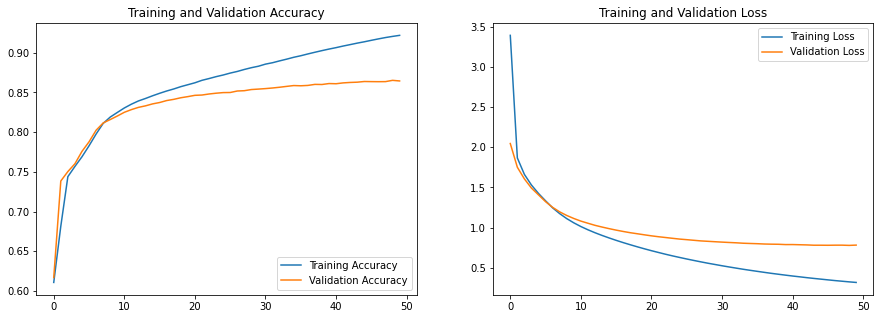

In [28]:
hist_plot(trans_hist)

그래프를 통해 알 수 있 듯, 훈련에서 큰 문제점은 찾아볼 수 없다.

loss 값도 우하향 곡선을 나타내고 있다.

### Step 6. 모델 평가하기

<hr>


~~~
단어 단위 번역기에 대해서 훈련 데이터의 샘플과 테스트 데이터의 샘플에 대해서 번역 문장을 만들어보고 정답 문장과 번역 문장을 비교해보세요.

모델 평가를 진행할때 우리가 공부했던 모델의 경우 글자 단위에서 구현된 번역기이며 현재 프로젝트를 진행할 때 사용하는 프로젝트는 단어 단위에서 구현되는 번역기입니다.

Embedding layer가 추가되기 때문에 학습했던 내용 그대로 사용할 경우 shape에서 error가 발생합니다.

decode sentence를 구성할때 고민해보세요!!

고민하다 풀리지 않을 경우에는 하단 내용 참고해주세요.
~~~
~~~python
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # 에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = fra2idx['\t']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # 에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence
~~~

~~~
seq2seq는 훈련 과정(교사 강요)과 테스트 과정에서의 동작 방식이 다릅니다. 그래서 테스트 과정을 위해 모델을 다시 설계해주어야 합니다. 특히 디코더를 수정해야 합니다. 이번에는 번역 단계를 위해 모델을 수정하고 동작시켜보겠습니다.

전체적인 번역 단계를 정리하면 아래와 같습니다.

1. 번역하고자 하는 입력 문장이 인코더로 입력되어 인코더의 마지막 시점의 은닉 상태와 셀 상태를 얻습니다.
2. 인코더의 은닉 상태와 셀 상태, 그리고 토큰 <sos>를 디코더로 보냅니다.
3. 디코더가 토큰 <eos>가 나올 때까지 다음 단어를 예측하는 행동을 반복합니다.

인코더의 입, 출력으로 사용하는 encoder_inputs와 encoder_states는 훈련 과정에서 이미 정의한 것들을 재사용합니다. 이렇게 되면 훈련 단계에 encoder_inputs와 encoder_states 사이에 있는 모든 층까지 전부 불러오게 되므로 결과적으로 훈련 단계에서 사용한 인코더를 그대로 재사용하게 됩니다. 이어서 디코더를 설계합니다. 테스트 단계에서는 디코더를 매 시점 별로 컨트롤 할 예정으로, 이를 위해서 이전 시점의 상태를 저장할 텐서인 decoder_state_input_h, decoder_state_input_c를 정의합니다. 매 시점 별로 디코더를 컨트롤하는 함수는 뒤에서 정의할 decode_sequence()로 해당 함수를 자세히 살펴봐야 합니다.
~~~

seq2seq 는 훈련 과정과 테스트 과정에서의 동작 방식이 다르다고 하였다.

평가를 위해 모델을 다시 설계해 주어야 할 필요가 있다.

이곳의 코드 구성 또한 기존 문자 Level 번역기의 구성을 크게 벗어나지 않도록 구성하도록 하겠다.

인코더의 입, 출력으로 사용하는 encoder_inputs와 encoder_states는 훈련 과정에서 이미 정의한 것들을 재사용하므로,

훈련 단계에 encoder_inputs와 encoder_states 사이에 있는 모든 층까지 전부 불러오게 된다.

결과적으로 훈련 단계에서 사용한 인코더 구성과 동일하다.

출력으로 encoder_states 를 통해 은닉,셀 상태를 사용한다는 것을 다시 한번 되새기자.

~~~python
    ## 인코더의 hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장.
    ## → 디코더에 전달
    encoder_states = [state_h, state_c]
~~~

In [29]:
## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
##  인코더
## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 인코더 모델의 경우 기존에 정의를 재사용
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          299008    
_________________________________________________________________
masking (Masking)            (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  [(None, 64), (None, 64),  33024     
Total params: 332,032
Trainable params: 332,032
Non-trainable params: 0
_________________________________________________________________


이제 디코더를 다시 설계한다.

이 부분이 상당히 이해하는데에 시간이 걸리고 굉장히 어려운 부분이다.

decode_sequence() 를 정의하지 않은 상태에서 이 부분이 나오다보니

코드 구성이, 흐름을 따라가며 이해하기 어렵게 구성이 되어있다.

decode_sequence() 를 위해, decoder_states_inputs 를 준비해 두었는데,

뒤에서 decode_sequence() 를 자세히 다루겠다~ 뭐가 뭔지 모르는 상태에서

그냥 모든건 decode_sequence() 에서 할꺼야~ 식으로 덮어두고 넘어가다보니,

집중력이 떨어지고, 흐름을 파악하는데 방해를 주기 때문이다.

되도록이면 뒤에 나오는 decode_sequence() 와 함께 보는것이 이해하는 것에 도움이 된다고 생각한다.

In [30]:
## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
##  디코더
## ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 이전 time step 에서의 …
## … hidden state를 저장하는 텐서 …
decoder_state_input_h = Input(shape=(hidden_units,))
## … cell state를 저장하는 텐서 …
decoder_state_input_c = Input(shape=(hidden_units,))
## …를 묶어서 하나의 변수로
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

## 테스트 단계에서는 디코더를 매 시점 별로 컨트롤 할 예정으로, 이를 위해서
## 이전 시점의 상태를 저장할 텐서인 
## decoder_state_input_h, decoder_state_input_c 를 정의.
## 매 시점 별로 디코더를 컨트롤하는 함수는 
## 뒤에서 정의할 decode_sequence() 를 살펴보아야 한다.


## 훈련 때 사용했던 임베딩 층을 재사용
decoder_embed_layer2 = decoder_embed_layer(decoder_inputs)

## 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
## → decoder_states_inputs 을 현재 time step의 초기 상태로 사용.
## （구체적인 동작 자체는 def decode_sequence()에 구현.）
decoder_outputs2, state_h2, state_c2 = \
    decoder_lstm(decoder_embed_layer2, initial_state=decoder_states_inputs)

## 현재 time step의 hidden state 와 cell state를 하나의 변수에 저장
decoder_states2 = [state_h2, state_c2]



## ──────────────────────────────────
##  디코더의 출력층 재설계
## ──────────────────────────────────

## 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

## 수정된 디코더
decoder_model = \
    Model(inputs=[decoder_inputs] + decoder_states_inputs,
          outputs=[decoder_outputs2] + decoder_states2)

decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     520768      input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 64)]         0                                            
____________________________________________________________________________________________

단어로부터 정수를 얻는데에 사용할 딕셔너리와,

정수로부터 단어를 얻는데에 사용할 딕셔너리를 각각 생성한다.

__이전에 생성 해 놓았었던 동일한 코드이다. 흐름상, 다시 코드를 배치했다.__

In [31]:
# eng2idx = tokenizer_eng.word_index
# idx2eng = tokenizer_eng.index_word
# fra2idx = tokenizer_fra.word_index
# idx2fra = tokenizer_fra.index_word

~~~
이제 예측 과정을 위한 함수 decode_sequence()를 구현합니다. decode_sequence()의 입력으로 들어가는 것은 번역하고자 하는 문장의 정수 시퀀스입니다. decode_sequence() 내부에는 인코더를 구현한 encoder_model이 있어서 이 모델에 번역하고자 하는 문장의 정수 시퀀스인 'input_seq'를 입력하면, encoder_model은 마지막 시점의 hidden state를 리턴합니다.
~~~

~~~python
# decode_sequence() 함수 내에 있는 코드
states_value = encoder_model.predict(input_seq)
~~~

~~~
이 hidden state는 디코더의 첫번째 시점의 hidden state가 되고, 디코더는 이제 번역 문장을 완성하기 위한 예측 과정을 진행합니다. 디코더의 예측 과정에서는 이전 시점에서 예측한 단어를 디코더의 현재 시점의 입력으로 넣어주는 작업을 진행합니다. 그리고 이 작업은 종료를 의미하는 종료 토큰을 만나거나, 주어진 최대 길이를 넘을 때까지 반복합니다.
~~~

decode_sequence 함수의 경우는, 기존 대비 아주 소소한 변경점이 있다.

노드 실습부분에서 제시한 예시를 거의 그대로 사용하는 경우, 

1. 첫글자에 공백이 들어가고, 

2. \<eos\> 가 끝부분에 출력이 된다.

3. 또한 글자길이 제한이 오히려 예기치 않게 문장이 잘리는 현상을 만들어 내기도 한다.

…의 현상을 발견할 수 있다.


해당 현상을 피하기 위해서,

1. 리턴 값에 좌우 공백을 제거하는 strip() 을 적용

2. 예측 단어를, 예측 문장에 추가하는 구문의 순서를 조정. 변경사항 3 도 영향.

3. 【if (sampled_word == "\<eos\>"):】부분 조건문 내에, <br>
stop_condition（의미는 없지만 남겨두었다.） 다음 부분에 루프를 빠져나가는 break 지정.

…의 변경이 있다. 사실 중요한 것은 아니다.

decode_sequence() 함수에 대해서 코드 주석문을 통해 개념 정리를 해 놓았다.

코드의 흐름을 따라가는 과정에서 【※ 중요】한 부분을 표시 해 놓았다.

①∼⑧ 에 유의하며 흐름을 따라가면 seq2seq 모델 이해에 도움이 될 것이라고 생각한다.

In [32]:
def decode_sequence(input_seq):
    
    ## ① 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
    ## 이 두개의 값을 ② states_value 에 할당
    states_value = encoder_model.predict(input_seq)

    ## ③ 디코더의 초기 입력으로 <sos>에 해당하는 정수 생성
    ## 이를 ④ target_seq 에 할당
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = fra2idx["<sos>"]    ## <sos>에 해당하는 정수
    
    ## while 루프에 사용
    stop_condition = False
    
    ## 반환값이 될 변수. 일단 빈 문자열로 지정.
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    while not stop_condition:
       
        ## ※ 중요
        ## ②, ④ 두개의 값을 디코더의 입력으로 사용
        ## 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        ## ⑤ output_tokens：현 시점의 예측 벡터
        ## ⑥ h：현시점의 은닉 상태
        ## ⑦ c：현시점의 셀 상태
        output_tokens, h, c = \
            decoder_model.predict([target_seq] + states_value)

        ## 아래에서는
        ## ⑤ output_tokens 의 예측 벡터로부터, 
        ## 현재 시점의 예측 단어인 ④ target_seq 를 얻는다.
        ## 그리고…
        ## ⑥ h：현시점의 은닉 상태, ⑦ c：현시점의 셀 상태 를 통해
        ## 현재시점의 ② states_value 를 만들어
        ## 다음 루프(시점)의 디코더 모델의 입력으로 사용할 것이다.
        
        ## 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = idx2fra[sampled_token_index]

        ## 도중 <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_word == "<eos>"):
            stop_condition = True
            break
        
        ## 현재 시점의 예측 단어를 예측 문장에 추가.
        ## 각 시점마다 번역된 단어는
        ## ⑧ decoded_sentence 에 누적하여 저장하였다가
        ## 루프를 빠져 나오면, 「최종 번역 시퀀스 값」으로 리턴된다.
        decoded_sentence += " " + sampled_word

        ## 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        ## 여기의 ④ target_seq 는, 다음 루프 시점의 디코더에 입력으로 사용될 것이다

        ## 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        ## ⑥ h：현시점의 은닉 상태, ⑦ c：현시점의 셀 상태 는
        states_value = [h, c]
        ## 다시 ② states_value 에 할당되어, 
        ## 바로 위의 ④ target_seq 와 함께, 
        ## 다음 루프 시점의 디코더에 입력으로 사용된다.

    return decoded_sentence.strip()

이렇게 구현한 함수를

임의의 인덱스의, 번역하고자하는 문장 샘플을 입력하여, 출력 결과를 테스트해보자.

결과 확인을 위한 함수를 정의한다.

seq_to_eng 함수는 영어 문장에 해당하는 정수 시퀀스를 입력받으면 idx2eng를 통해 정수로부터 영어 단어를 변환하여 리턴한다.

seq_to_fra 함수는 프랑스어에 해당하는 정수 시퀀스를 입력받으면 idx2fra를 통해 정수로부터 프랑스어 단어를 변환하여 리턴한다.

In [33]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_eng(input_seq):
    sentence = ""
    for encoded_word in input_seq:
        if(encoded_word != 0):
            sentence = sentence + idx2eng[encoded_word] + " "
    return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_fra(input_seq):
    sentence = ""
    for encoded_word in input_seq:
        if(encoded_word != 0 and 
           encoded_word != fra2idx["<sos>"] and 
           encoded_word != fra2idx["<eos>"]):
            sentence = sentence + idx2fra[encoded_word] + " "
    return sentence

테스트 데이터에 대해서 임의로 선택한 인덱스 샘플 몇개의 번역 결과를 출력해보자.

In [143]:
import googletrans
from googletrans import Translator
print(googletrans.__version__)
translator = \
    Translator(service_urls=
               ["translate.google.co.kr",])

3.0.0


파이써닉한지 어떤지 모르겠는데, 세번째 루브릭을 그럴싸한 출력으로 달성을 해보고자, 

LMS 환경의 주피터 노트북에 설치되어있는 gooletrans를 활용해 보도록 하겠다.

In [145]:
# for seq_index in np.random.randint(30000, size=10):
#     input_seq = encoder_input_train[seq_index: seq_index + 1]
#     decoded_sentence = decode_sequence(input_seq)
    
#     ## 변수에 할당
#     input_sent = seq_to_eng(encoder_input_train[seq_index])
#     correct_sent = seq_to_fra(decoder_input_train[seq_index])
#     pred_sent = decoded_sentence
    
#     ## 이하의 gt 접두어로 시작하는 변수는 구글번역 패키지를 사용하여 한글 번역한 결과
#     gt_input_sent = translator.translate(input_sent)
#     gt_input_sent = translator.translate(text=input_sent, src="en", dest="ko")
#     gt_correct_sent = translator.translate(text=correct_sent, src="fr", dest="ko")
#     gt_pred_sent = translator.translate(text=pred_sent, src="fr", dest="ko")
    
#     print("seq_index :", seq_index)
#     print("입력문장 :", input_sent, " → ", gt_input_sent)
#     print("정답문장 :", correct_sent, " → ", gt_correct_sent)
#     print("번역문장 :", pred_sent, " → ", gt_pred_sent)
#     print("─" * 64)

제대로 사용한다고 했는데, 도무지 잘 동작하지 않는다.

버전도 낮고 업그레이드 권한도 없고 뭔가 문제가 있는 것 같아서,

여기서는 사용을 할 수 없는 것 같다. 이걸로 3시간 헤맸다.

그냥 넘어가고, 직접 수작업 하는 수 밖에 없겠다.

우선 훈련 데이터의 샘플에서 무작위로 5개 정도만 추출해 보겠다.

In [148]:
for seq_index in np.random.randint(30000, size=5):
    input_seq = encoder_input_train[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("seq_index :", seq_index)
    print("입력문장 :", seq_to_eng(encoder_input_train[seq_index]))
    print("정답문장 :", seq_to_fra(decoder_input_train[seq_index]))
    print("번역문장 :", decoded_sentence)
    print("─" * 64)

seq_index : 12279
입력문장 : your cat is fat . 
정답문장 : ton chat est gras . 
번역문장 : ton chat est grosse .
────────────────────────────────────────────────────────────────
seq_index : 25825
입력문장 : have a nice day ! 
정답문장 : bonne journee ! 
번역문장 : bonne journee !
────────────────────────────────────────────────────────────────
seq_index : 27916
입력문장 : she likes sleeping . 
정답문장 : elle apprecie de dormir . 
번역문장 : elle aime des echecs .
────────────────────────────────────────────────────────────────
seq_index : 1884
입력문장 : are you all lost ? 
정답문장 : vous etes perdus ? 
번역문장 : etes vous perdues ?
────────────────────────────────────────────────────────────────
seq_index : 3595
입력문장 : everything worked . 
정답문장 : tout a fonctionne . 
번역문장 : tout a fonctionne .
────────────────────────────────────────────────────────────────


 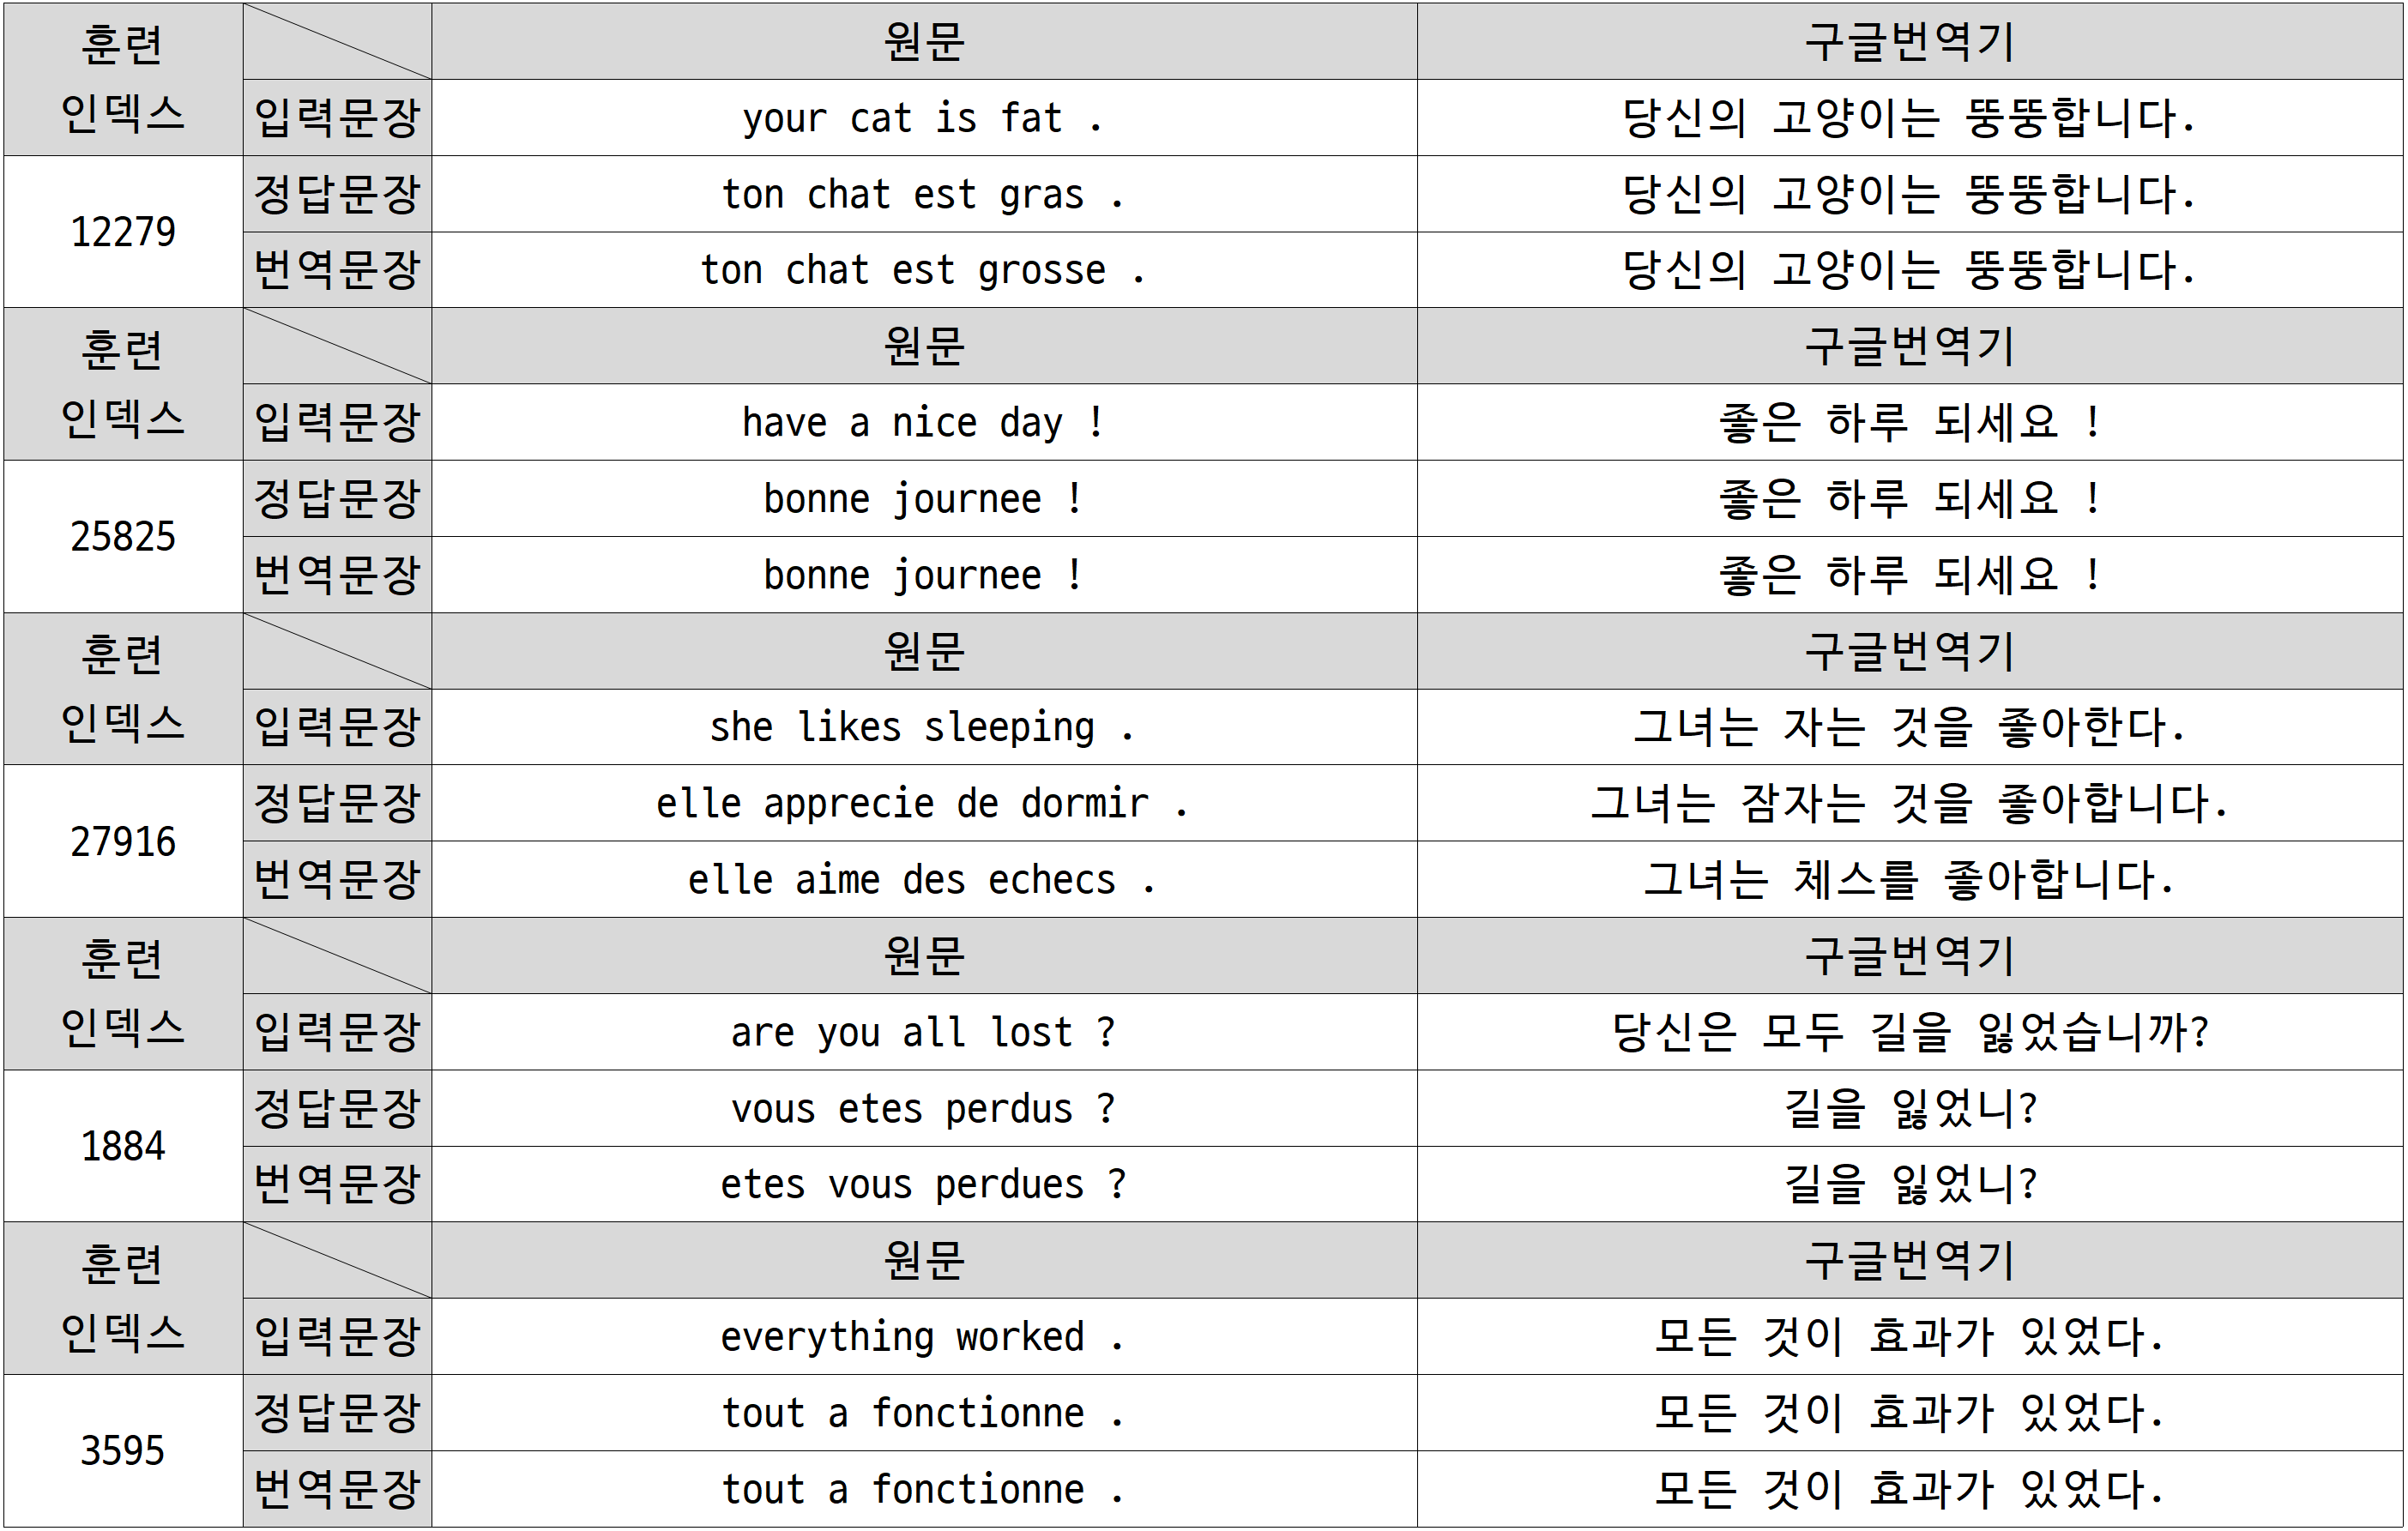

이번에는 테스트 데이터의 샘플에서 무작위로 5개 정도만 추출해 보겠다.

In [141]:
for seq_index in np.random.randint(3000, size=5):
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("seq_index :", seq_index)
    print("입력문장 :", seq_to_eng(encoder_input_test[seq_index]))
    print("정답문장 :", seq_to_fra(decoder_input_test[seq_index]))
    print("번역문장 :", decoded_sentence)
    print("─" * 64)

seq_index : 889
입력문장 : i m a big boy now . 
정답문장 : je suis un grand garcon maintenant . 
번역문장 : je suis un grand garcon .
────────────────────────────────────────────────────────────────
seq_index : 544
입력문장 : don t resist . 
정답문장 : ne resiste pas ! 
번역문장 : ne nous pas pas !
────────────────────────────────────────────────────────────────
seq_index : 701
입력문장 : i m ugly . 
정답문장 : je suis laid . 
번역문장 : je suis laide .
────────────────────────────────────────────────────────────────
seq_index : 1340
입력문장 : why are you lying ? 
정답문장 : pourquoi mens tu ? 
번역문장 : pourquoi es tu occupe ?
────────────────────────────────────────────────────────────────
seq_index : 2909
입력문장 : i want a beer . 
정답문장 : je veux une biere . 
번역문장 : je veux une biere .
────────────────────────────────────────────────────────────────


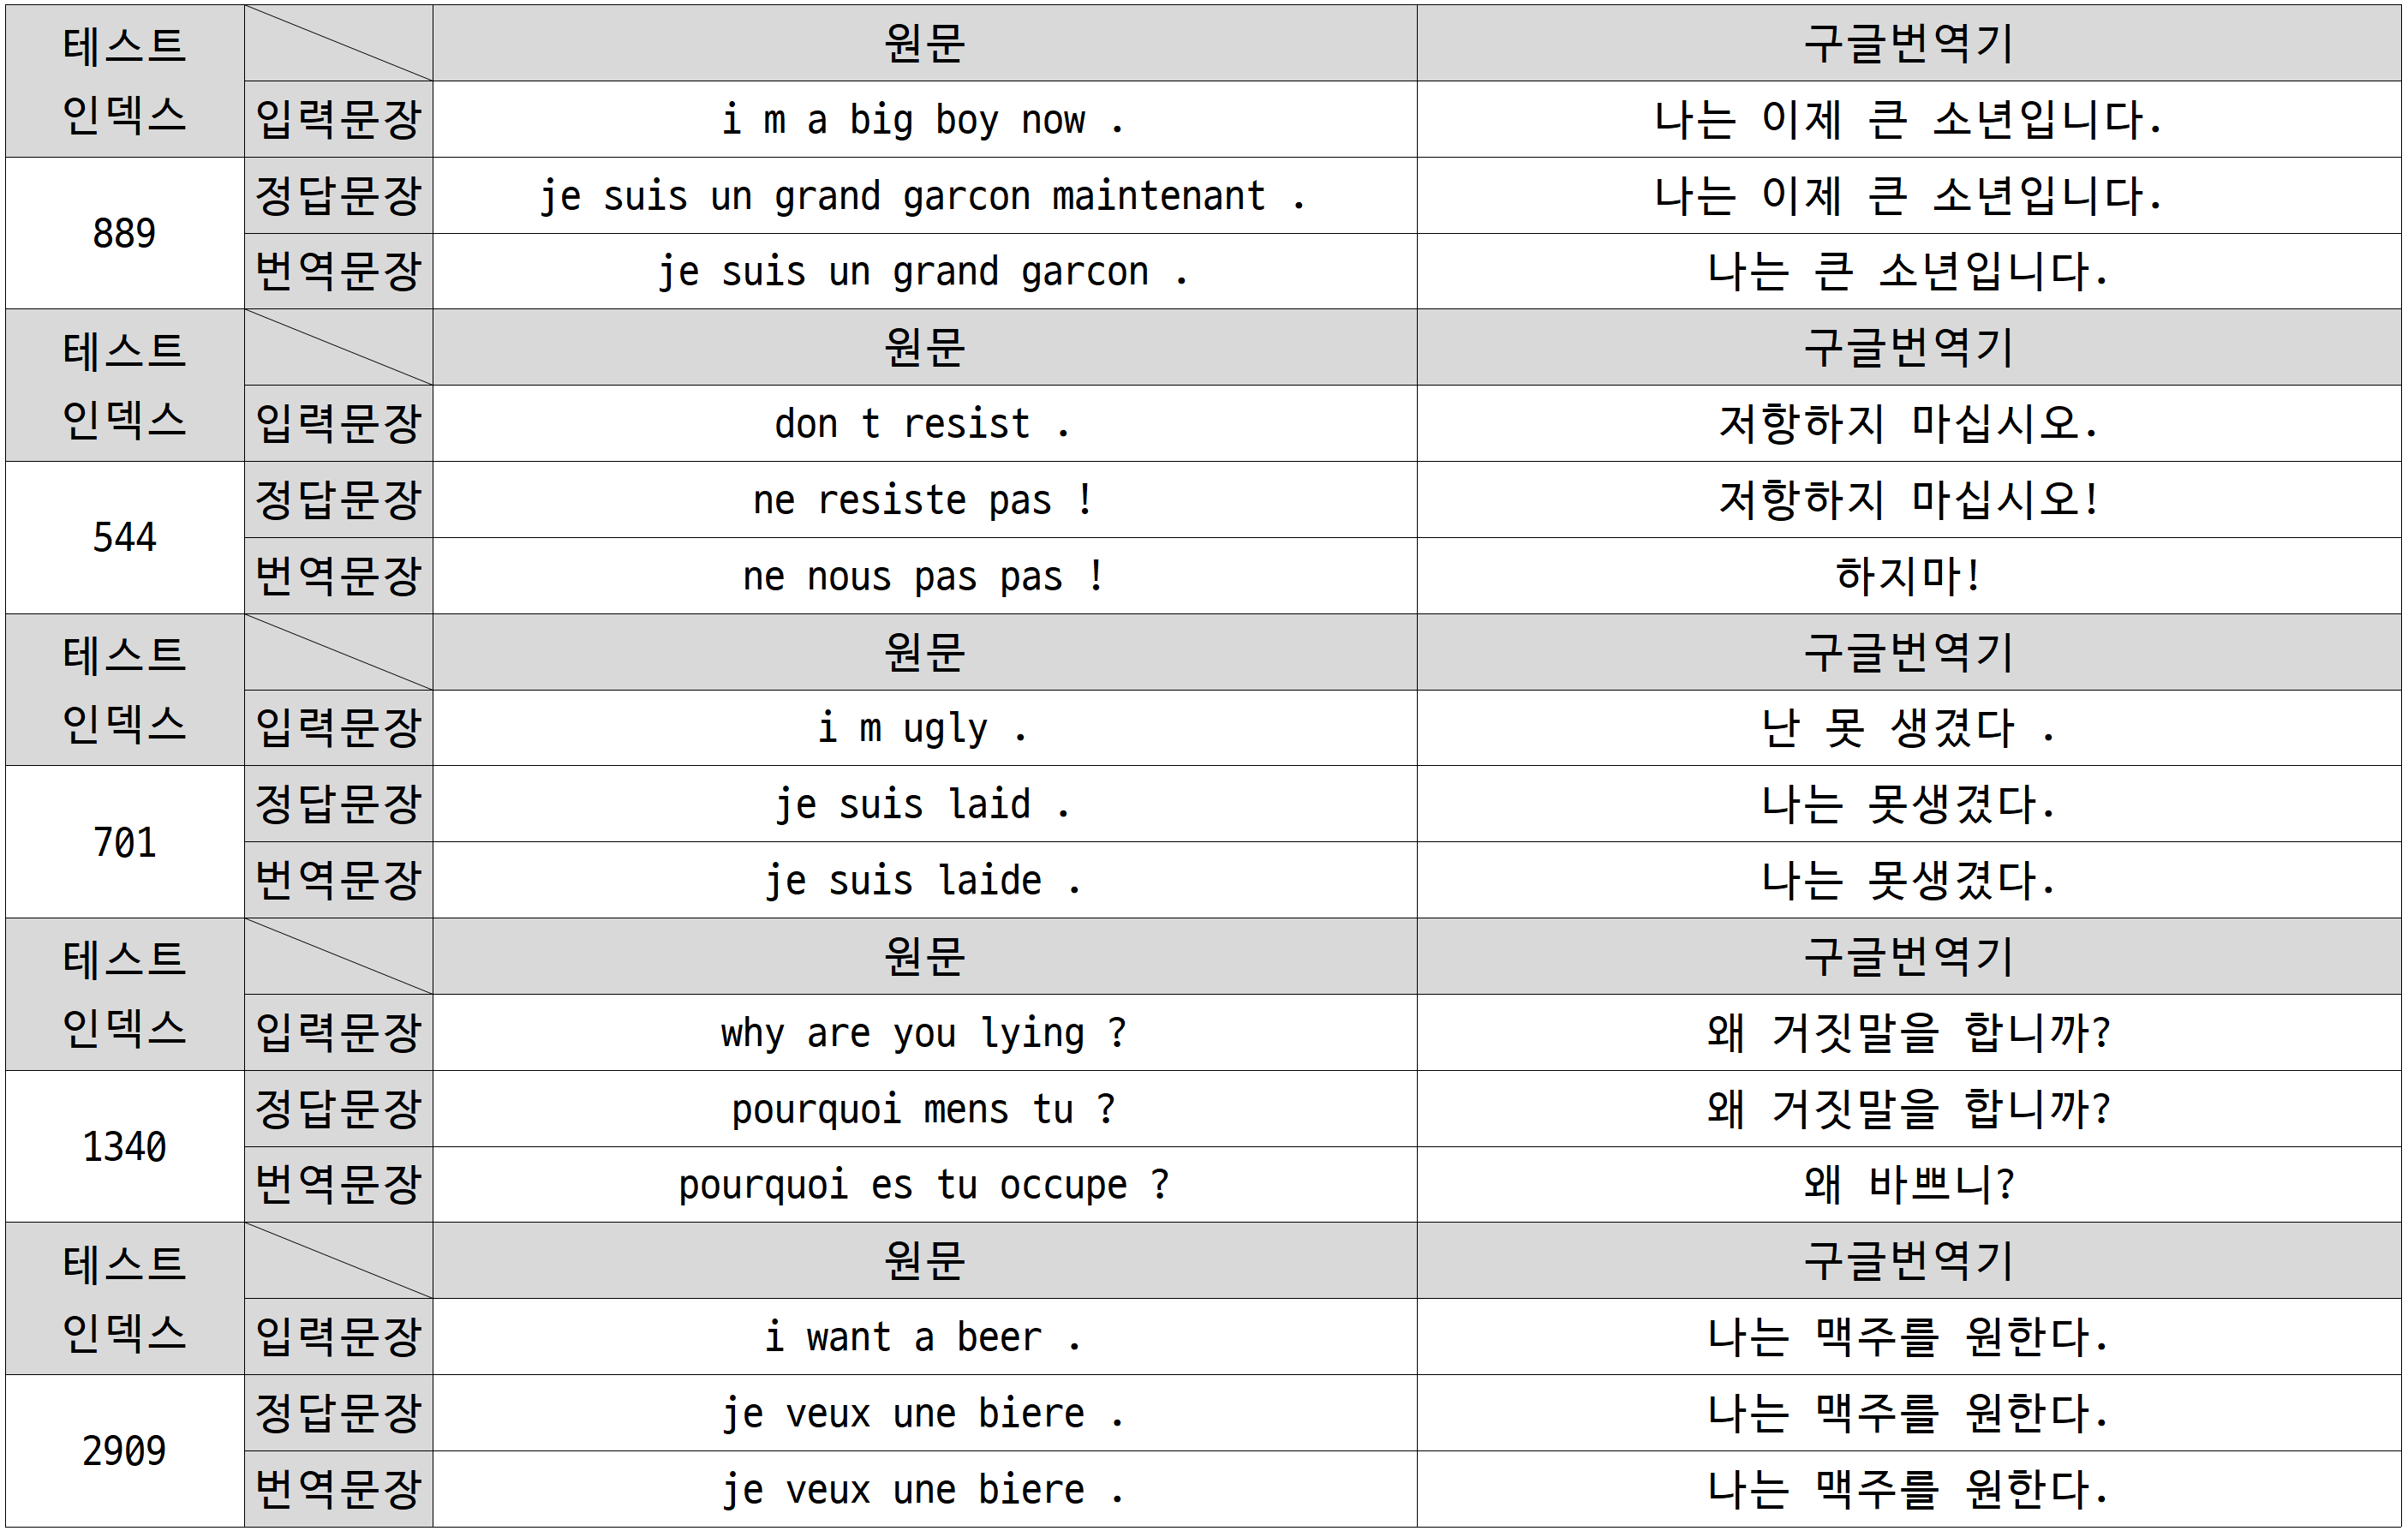

이게 잘 될까 의문스러웠는데, 역시 구글인가.

구글이 사용했다는 모델 답게, 리소스 대비 상당히 괜찮은 성능으로 보인다.

고작 3.3만건의 데이터와 그리 길지 않은 학습 시간으로 이정도 결과는 솔직히 기대 이상이다.

<hr>

### ■ 프로젝트 회고

#### 1) 이번 프로젝트에서 '어려웠던 점'

초반부의 그림과 수식에 대한 설명이 전혀 이해가 안가서, 내용을 이해하는데에 오랜 시간이 걸렸다.

이 프로젝트가 자꾸 신경쓰여서 다른 프로젝트 노드들에 집중할 수가 없었다.

프로젝트 시작 단계에서 어떻게 해야 할 지 막막하기도 하고 머릿속이 백지상태여서 마음고생이 정말 심했다.

노드 학습 부분에서 그림에 화살표가 한번에 다 나와 있다보니 뭐가 뭔지 흐름을 이해하기 너무 어려웠는데,

먼저 앞서간 교육생 분들의 설명을 통해, 대강의 흐름을 파악하고,

코드를 한줄 한줄 작성하면서 순서를 파악하고나니 조금씩 진행이 되기 시작했다.

노드 실습 부분도 잘 이해가 안돼서 실행과 다음 페이지만 클릭했었는데,

다시 보면서 차근차근 하면서 진행하다보니 실습 과정 부분도 구성이 좀 정리가 덜돼서 그렇지,

각각의 요소에 대해서는 설명이 잘 되어 있음을 알게 되었다.

#### 2) 프로젝트를 진행하면서 본인이 '학습한 내용'

이번 프로젝트는 번역기 모델 하나만 다룬다. 

노드 초반 학습 부분에서는 번역기 구현에 대한 컨셉을 설명하고 있고,

중반 실습 부분 부터는 문자 → 단어 단위의 번역기 만들기 실습과 프로젝트가 거의 전부라고 할 수 있는 내용이다.

초반 학습 부분에서 좌절해서 여러번 봐도 이해가 잘 안됐는데, 참고자료들과 실습을 반복하며

번역기 모델 구조의 특징을 파악하였다.

무엇보다 이 프로젝트의 완성에 가장 영향을 주었다고 할 수 있는 부분은,

디코더 인코더의 역할을 분명히 구분하여 이해하고,

조각조각 흩어진 state 들과 time step 의 흐름을 집요하게 따라가며

학습을 진행했던 것이, 과제 해결의 길이 보이기 시작하는 시점이었다고 생각한다.

이 부분의 학습이 덜 됐을 때, 참 막막 했었던 기억이 스쳐 지나간다…

#### 3) 프로젝트를 진행하면서 '알아낸 점' 혹은 '아직 모호한 점'

『이 변수들은 왜 여기에？』, 『이건 또 어디에 쓰려고？』 계속 이런 생각들 뿐이었다.

처음에는 지금까지 경험해온 프로젝트들과 신경망 구조가 너무 다른거 같아서

어디서 부터가 모델이고 어디서부터가 레이어 인지도 헷갈렸고, 인코더와 디코더의 역할도 잘 이해 못했었다.

그렇게, 입력에 쓰이는 인코더와 디코더를 함께 사용 한다거나, 

은닉, 셀 스테이트를 저장해서 계속 다음 처리의 입력값으로 사용하는

seq2seq 의 특징적인 구조에 대해서 쭈욱 이해를 못하다가, 

최근 들어서 실습의 반복과 프로젝트 진행을 병행하면서 조금씩 그런 구조들을 이해하게 됐다.

모호한 점은, 

프로젝트를 거의 마무리 할 시점에 이해를 어느정도 한 상황에서 든 생각인데,

문자 단위가 더 복잡하고 이해하기 어렵다는 생각이다.

그런데 어디가 단어보다 문자 단위 구조가 더 간단하다는 걸까？ 아직도 이해가 안된다.

워드 단위가 더 파악하기가 쉬운거 같은데… 내가 모르는 다른 뭔가가 있는 것인지？

#### 4) 루브릭 평가 지표를 맞추기 위해 '시도한 것들'

이번 프로젝트도 NLP 파트의 다른 프로젝트들과 유사한 특성이랄까,

완성이 정말 어렵지, 루브릭 평가 지표는 어지간해선 되더라ㅡ 하는 점이다.

전혀 이해를 못하던 시기에는 뭘 붙여넣어도 다 결과가 이상하고,

새로 만들자니 어떻게 해야 할 지도 막막해서 코드 한줄을 작성하기가 어려웠다.

문자 Level 번역기 부분을 실행만 하기 보다는,

다 하나하나 붙여보고 실행하면서 학습을 포기하지 않고 진행한 그 결과,

다행스럽게도 프로젝트를 마무리 할 수 있었으니…

학습한 내용 참고하며 프로젝트 진행 하는 과정에서,

구성이나 순서가 딱 본다고 이해 될 정도의 내용은 아니라 제법 집중하고

위에 말한 중요한 부분을 파고 들려고 마음을 먹어야 하는것 같다.

진행 하는 도중, 중간 중간에서 루브릭 평가 지표는 달성이 되는것을 확인 했다.

다행스럽게도 진행 중에 그냥 되는구나 하고 안도의 한숨을 내쉬면서,

특별한 시도는 기재할 만한 사항이 없지만, 

프로젝트 마무리 하고 완성한 것이 특별한 시도라고 할 수 있을지도 모르겠다.

#### 5) 만약에 '루브릭 평가 지표를 달성하지 못했을 때, 이유에 관한 추정'

첨엔 완성 자체를 못할 것 같았어서, 이번 프로젝트는 글렀다고 생각했다.

『루브릭 평가 지표는 당연히 전부 꽝에, 제출도 못하는거 아니야？』 라고 생각했는데,

내용이 어려우니 루브릭이 너그러운듯 한 느낌을 받은건 나만의 착각일까…

아마도 노드의 실습 부분에서 루브릭 평가 달성을 유도하는 방향으로 학습 내용이 구성되어 있기 때문에,

성실하게 학습 한다면 달성은 어렵지 않게 될 것이라고 생각한다.

전부 달성 아니면 제출 실패 … 의 극과 극 느낌이다.

매번 프로젝트를 이렇게 위태위태하게 진행하고 있으니 참 맘고생이 많다.

#### 6) 자기 다짐

갈수록 프로젝트는 점점 복잡해지고, 어려워지고, 

모델 훈련 소요시간도 나날이 늘어만 가니, 힘들고 지치는 것 같다.

퍼실분들 말씀대로, 텐션을 좀 올려야 할 것 같다는 것에 동의하고,

좀 더 학습에 집중해야 할 거 같다는 생각은 드는데…

이게 참 말처럼 쉽지 않은 것 같다.

이번 프로젝트 처럼 이해하는 과정에서 시간을 많이 소요하면, 때때로 포기할까도 생각이 든다.

그럴 시간에 처음부터 끝까지 노드나 한번 더 보면 좋았을 것을…

이번 프로젝트는 막바지에 다다르고서야 머릿속에서 정리가 되고

그제서야 프로제트가 진행이 된 경우이다보니, 어떻게 보면 다른 부분에는 신경을 못 써서,

프로젝트에 해당하는 내용에만 집중하다보니, 내 주관이지만 내용 자체는 간결해 진 느낌이다.

하지만 프로젝트 외적인 다른 부분들에 대해서는 거의 내용이 없다시피 하다.

그렇더라도, 이 프로젝트 제출 파일을 처음부터 끝까지 여러번 검토 해 보았으나,

중요한 내용을 빼먹었다거나, 루브릭 달성 과제에 대한 부분을 놓치거나 한 것은 없으니,

본의 아니게 상당한 고효율을 추구한 프로젝트 내용이 된 것 같다.

요즘 Exploration node 트렌드가, 내가 감당하기에 많이 버거운 주제나 어려운 내용이 많다보니,

이번 프로젝트와 같은 방법이나, 아니면 다른 좀 더 효율적인 시간 분배를 통해,

남은 과정 동안 잘 버텨낼수 있는, 비유하자면 뭐 멘탈의 근육 같은것을 키운다던가 해야겠다.

물론 그게 말처럼 쉽게 될리는 없을테지만…

<hr>

## ◎ Reference

- (AIFFEL) Exploration Project Node 10. 번역기를 만들어보자

- [tf.keras.preprocessing.text.Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#fit_on_texts)

- [A ten-minute introduction to sequence-to-sequence learning in Keras](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)

- [Attention in RNN-Encoder-Decoder](https://sonsnotation.blogspot.com/2020/11/11-attention-transformer-models.html)

- [케라스를 이용해 seq2seq를 10분안에 알려주기](https://tykimos.github.io/2018/09/14/ten-minute_introduction_to_sequence-to-sequence_learning_in_Keras/)

- [딥러닝을 활용한 번역기를 만들어보자!(python keras seq2seq translate model)](https://lsjsj92.tistory.com/m/449)

- [Sequence-to Sequence](https://boysboy3.tistory.com/m/113)

- [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)

<hr>

~~~

- 10분이면 seq2seq 충분히 이해 가능하…

- 응~ 아니야~~ 10시간 으로도 모자라~

~~~

복잡한 RNN 구조 설명해 주시려고 해주신 구본회 교육생

새벽시간에도 이번 프로젝트 진행하며서 조심해야 할 사항들 미리 알려주신 선구자 장문규 교육생

두분께 고마움을 전해드리며 마칩니다.